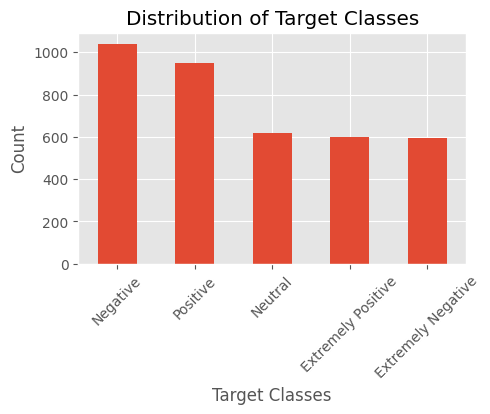

In [ ]:
#https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv("/content/Corona_NLP_test.csv", encoding='latin-1')

target_class_counts = df['Sentiment'].value_counts()

# Plotting the distribution of target classes
plt.figure(figsize=(5, 3))
target_class_counts.plot(kind='bar')
plt.title('Distribution of Target Classes')
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.show()

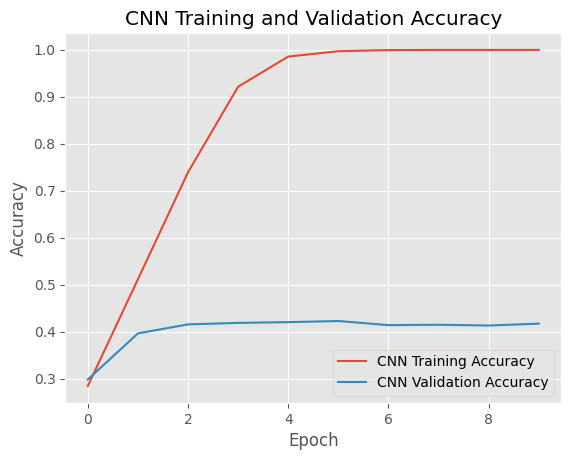

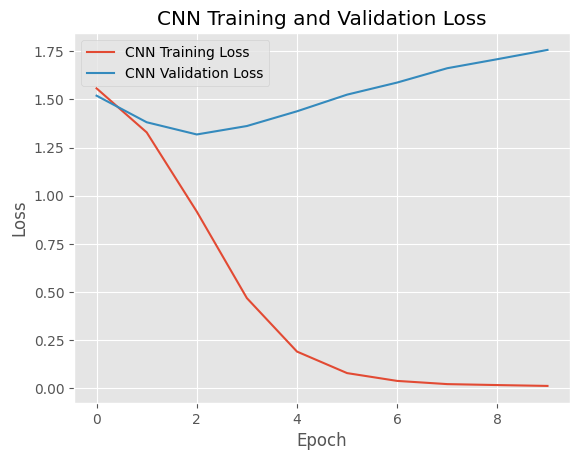

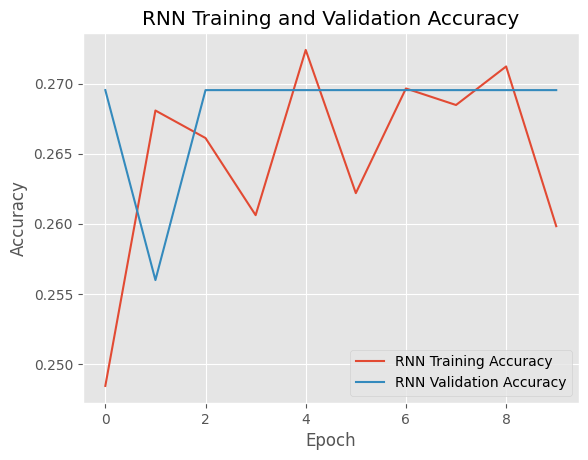

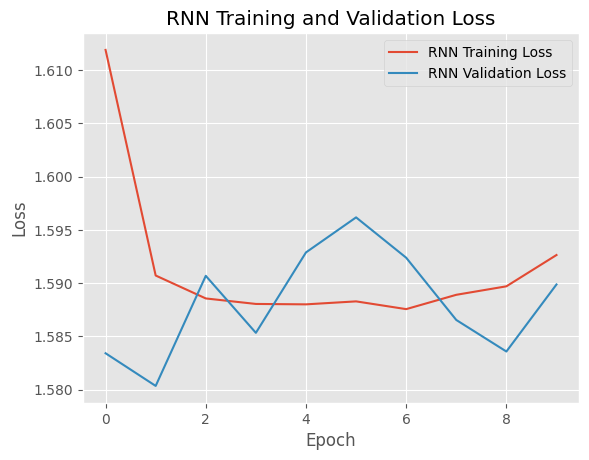

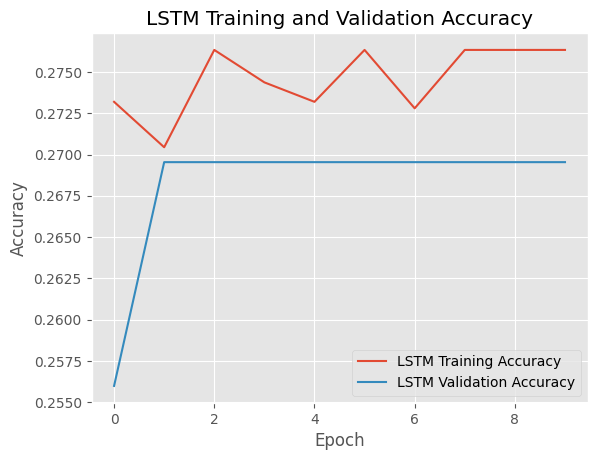

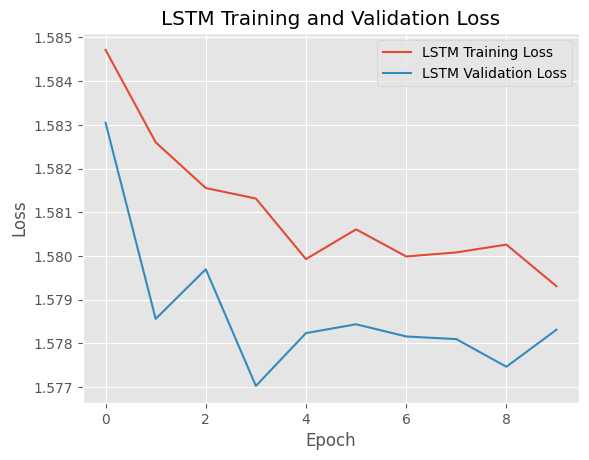

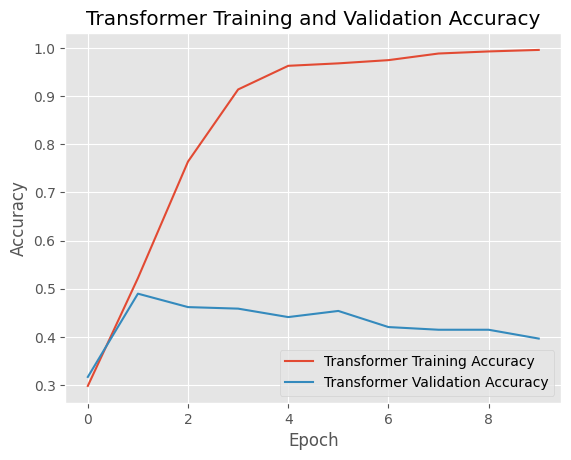

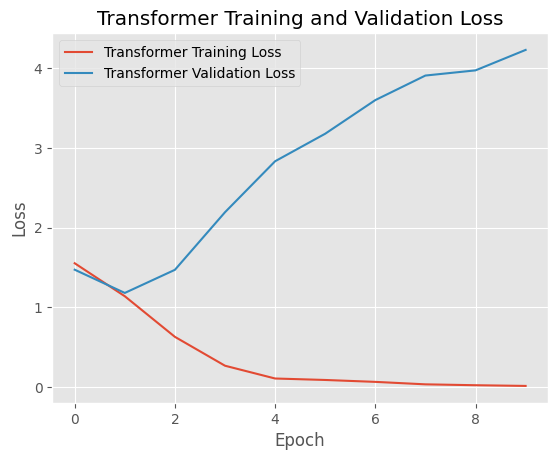

CNN Test Accuracy: 0.4170653820037842
CNN Test Loss: 1.7567027807235718
RNN Test Accuracy: 0.26953747868537903
RNN Test Loss: 1.5898774862289429
LSTM Test Accuracy: 0.26953747868537903
LSTM Test Loss: 1.578312873840332
Transformer Test Accuracy: 0.3963317275047302
Transformer Test Loss: 4.229410648345947


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load data from CSV
df = pd.read_csv("/content/Corona_NLP_test.csv")

# OriginalTweet is the text that needs to be classified
# Sentiment is the target

# Remove unnecessary features
target = df.pop('UserName')
target = df.pop('TweetAt')
target = df.pop('ScreenName')
target = df.pop('Location')

OriginalTweets = df['OriginalTweet'].values  # This is all the tweets (Feature)
y = df['Sentiment'].values  # This is all the sentiments (Targets)

tweets_train, tweets_test, y_train, y_test = train_test_split(OriginalTweets, y, test_size=0.33, random_state=1000)

# Tokenize
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets_train)
X_train = tokenizer.texts_to_sequences(tweets_train)
X_test = tokenizer.texts_to_sequences(tweets_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Padding
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Label encoding for targets (Make the string for y numerical)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define embedding dimension
embedding_dim = 100
num_classes = len(label_encoder.classes_)

# CNN Model
cnn_model = Sequential()
cnn_model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
cnn_model.add(layers.Conv1D(32, 5, activation='relu'))
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # Change loss function
                  metrics=['accuracy', 'sparse_categorical_accuracy'])  # Add metrics for evaluation

# RNN Model
rnn_model = Sequential()
rnn_model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
rnn_model.add(layers.SimpleRNN(units=128, return_sequences=True))  # Adding more complexity
rnn_model.add(layers.SimpleRNN(units=64))  # Adding more complexity
rnn_model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # Change loss function
                  metrics=['accuracy', 'sparse_categorical_accuracy'])  # Add metrics for evaluation

# LSTM Model
lstm_model = Sequential()
lstm_model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
lstm_model.add(layers.LSTM(units=128, return_sequences=True))  # Adding more complexity
lstm_model.add(layers.LSTM(units=64))  # Adding more complexity
lstm_model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',  # Change loss function
                   metrics=['accuracy', 'sparse_categorical_accuracy'])  # Add metrics for evaluation

# Custom Transformer Layer - CHATGPT generated this for me as I was stuck on a function not being recognized
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, d_model, num_layers, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([layers.Dense(64, activation='relu'),
                                         layers.Dense(d_model)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Transformer Model
transformer_model = Sequential()
transformer_model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
transformer_model.add(layers.Dropout(0.2))  # Dropout for regularization
transformer_model.add(TransformerBlock(num_heads=2, d_model=embedding_dim, num_layers=4, dropout=0.2))
transformer_model.add(layers.GlobalAveragePooling1D())
transformer_model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
transformer_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy', 'sparse_categorical_accuracy'])
# Training CNN Model
cnn_history = cnn_model.fit(X_train, y_train_encoded,
                            epochs=10,
                            verbose=False,
                            validation_data=(X_test, y_test_encoded),
                            batch_size=10)

# Training RNN Model
rnn_history = rnn_model.fit(X_train, y_train_encoded,
                            epochs=10,
                            verbose=False,
                            validation_data=(X_test, y_test_encoded),
                            batch_size=10)

# Training LSTM Model
lstm_history = lstm_model.fit(X_train, y_train_encoded,
                              epochs=10,
                              verbose=False,
                              validation_data=(X_test, y_test_encoded),
                              batch_size=10)

# Training Transformer Model
transformer_history = transformer_model.fit(X_train, y_train_encoded,
                                            epochs=10,
                                            verbose=False,
                                            validation_data=(X_test, y_test_encoded),
                                            batch_size=10)

# Plotting CNN Training History
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting RNN Training History
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting LSTM Training History
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Transformer Training History
plt.plot(transformer_history.history['accuracy'], label='Transformer Training Accuracy')
plt.plot(transformer_history.history['val_accuracy'], label='Transformer Validation Accuracy')
plt.title('Transformer Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(transformer_history.history['loss'], label='Transformer Training Loss')
plt.plot(transformer_history.history['val_loss'], label='Transformer Validation Loss')
plt.title('Transformer Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate CNN Model
cnn_test_loss, cnn_test_accuracy, _ = cnn_model.evaluate(X_test, y_test_encoded, verbose=0)
print("CNN Test Accuracy:", cnn_test_accuracy)
print("CNN Test Loss:", cnn_test_loss)

# Evaluate RNN Model
rnn_test_loss, rnn_test_accuracy, _ = rnn_model.evaluate(X_test, y_test_encoded, verbose=0)
print("RNN Test Accuracy:", rnn_test_accuracy)
print("RNN Test Loss:", rnn_test_loss)

# Evaluate LSTM Model
lstm_test_loss, lstm_test_accuracy, _ = lstm_model.evaluate(X_test, y_test_encoded, verbose=0)
print("LSTM Test Accuracy:", lstm_test_accuracy)
print("LSTM Test Loss:", lstm_test_loss)

# Evaluate Transformer Model
transformer_test_loss, transformer_test_accuracy, _ = transformer_model.evaluate(X_test, y_test_encoded, verbose=0)
print("Transformer Test Accuracy:", transformer_test_accuracy)
print("Transformer Test Loss:", transformer_test_loss)



Data is loaded and reduced to only the text classification feature itself, as well as its target. This data is then split approproiately into a test and training split. The tokenizing of the data guarantees a valid represenation in vector (numerical) form. Padding ensures that all the vectors have the same length. Label encoding ensures the same for the y labels (targets). From here the three models and created, trained, and displayed. I have added a reasonable amount of layers of complexity but still have a very low accuracy rate overall of around 15% for each model. The loss functions still do not make much sense to me as they are severly negative.

Now I will adjust the loss function to categorical_crossentropy from binary_crossentropy. I have more than 2 classes so this should impact the accuracy of the model. Results have drastically improved and the loss functions have more or less stabalized.

The CNN model is now overfitting, I will remove a few layers and access. I have a slight performance increase, I will adjust the test size from .25 to .33

validation loss > training loss = overfitting/underfitting
They should line up together for a good fit

So at this point I am having troublel improving my results even though I have adjusted the models, and training pre processing various times.

I added dropout layers and stops to help prevent the overfitting issue.

Reducing the CNN nodes from 32 to 8 has shown better results.

I have added a (0,1) range function for my CNN which has improved results and likely helps with vanishing gradients problem. As the activation functions are also more sensitive to 0s, it helps.

I adjusted the CNN to process 5 words at a time.

All models are now running much more efficiently but overfitting seems to still be a challenge. Regardless, at this point the CNN model is running the best.

The transformer ourperformed the CNN but also seems to be having trouble with overfitting.

Unfortuantley I have run out of time to further adjust my models, but the Transformer performs the best, while the CNN performs second best. The other models seem to be useless as of now, but since most of my time was spent figuring out the CNN and the Transformer I was not able to perfect these. I do realize that the main problem here is overfitting, and I have adjusted all the basics in the models but my tinkering has not helped much, at most a 5% increase in accuracy. However again, the data indicates that the overfitting issue is present as the training data seems to "memorize". The training loss being so low and the validation not following is an indication of this problem.